<a href="https://colab.research.google.com/github/ppuentex/ML_project/blob/main/LSTM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Patricia Puente 
#### Title: Is it possible to predict annual streamflow using climate indices with a machine learning model? 
#### ECE 523 

Import packages and data necessary. 

In [2]:
#packages needed 
import numpy as np 
import pandas as pd  #dataframe 
from sklearn.preprocessing import StandardScaler #normalize data set 
import matplotlib.pyplot as plt #plots 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout


#grab data from Github 
SF_url = "https://raw.githubusercontent.com/ppuentex/ML_project/main/data/MultiObserved_data.csv"
ENSO_url = "https://raw.githubusercontent.com/ppuentex/ML_project/main/data/nino3_4_monthly_record.csv"
PMDI_url = "https://raw.githubusercontent.com/ppuentex/ML_project/main/data/UCR_basinAvg_PMDI_0to2017.csv"
#import data needed 
ENSO = pd.read_csv(ENSO_url, header=None)
PMDI = pd.read_csv(PMDI_url)
SF = pd.read_csv(SF_url)


Manipulate data to be in the form that is necesary. \
For ENSO data, this is in the form of monthly values so we neeed to take the average for each year to get the annual value.\
For SF data, this is a data set with other observed streamflow locations and need to convert from acre feet to million acre feet. 

In [3]:
#calculate the average of each row b/c original is monthly data and we need annual
ENSO['Mean'] = ENSO.iloc[:, 1:12].mean(axis=1)
#grabbing data from dates 1906 to 2017 which is the period of record
ENSO_data = ENSO.iloc[36:148, [0,13]]
ENSO_data = ENSO_data.reset_index(drop=True) #reset the index for concatinating 
ENSO_data.columns = ["Year", "ENSO"] #rename columns 
#grabbing data from dates 1906 to 2017 which is the period of record
PMDI_data = PMDI.iloc[1906:2018,[0,1]]
PMDI_data = PMDI_data.reset_index(drop=True)
PMDI_data.columns = ['Year', 'PMDI']
#grabbling only the first two columns for year and location of Lees Ferry gage 
SF_data = SF.iloc[0:112,[0,1]]
SF_data.columns = ["Year", "Streamflow"]
#put values of streamflow in Million Acre Feet (MAF) by dividing by 1e6
SF_data.iloc[:,1] = SF_data.iloc[:,1].div(1e6)

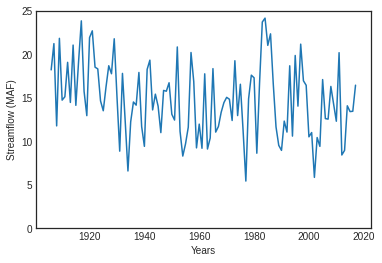

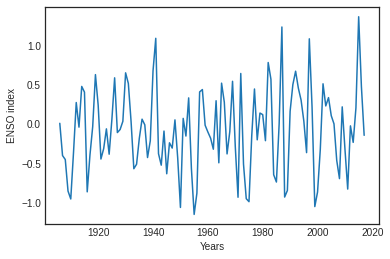

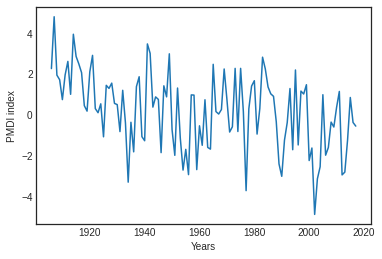

In [5]:
plt.style.use('seaborn-white')
#plt.figure(dpi=150) #uncomment these to make figures look better for saving purposes
plt.plot(SF_data['Year'], SF_data['Streamflow']) #streamflow plot 
plt.ylim(0,25)
plt.ylabel("Streamflow (MAF)")
plt.xlabel('Years')
plt.show()
#plt.figure(dpi=150)
plt.plot(ENSO_data['Year'], ENSO_data['ENSO']) #ENSO plot 
plt.ylabel("ENSO index")
plt.xlabel('Years')
plt.show()
#plt.figure(dpi=150)
plt.plot(PMDI_data['Year'], PMDI_data['PMDI'])
plt.ylabel("PMDI index")
plt.xlabel("Years")
#PMDI_data.plot('Year','PMDI', title = "PMDI annual")
plt.show()

Is PMDI and ENSO related to Streamflow?\
Use scatterplots to see this. 

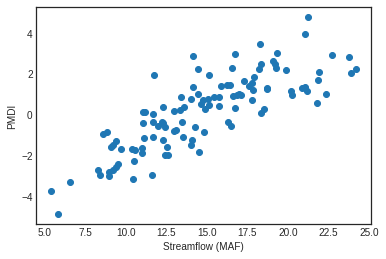

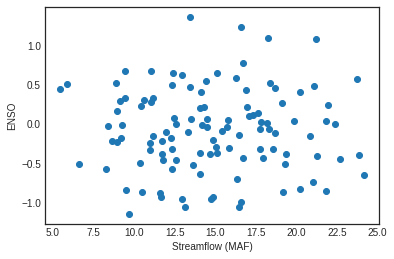

In [6]:
#plt.figure(dpi=150)
plt.scatter(SF_data["Streamflow"], PMDI_data["PMDI"])
plt.xlabel("Streamflow (MAF)")
plt.ylabel("PMDI")
#plt.title("Scatterplot of SF and PMDI")
plt.show()

#plt.figure(dpi=150)
plt.scatter(SF_data["Streamflow"], ENSO_data["ENSO"])
plt.xlabel("Streamflow (MAF)")
plt.ylabel("ENSO")
#plt.title("Scatterplot of SF and ENSO")
plt.show()

Put the data in dataframe in order to start training and testing for LSTM model. 

In [7]:
data = [SF_data["Year"], SF_data["Streamflow"], ENSO_data["ENSO"], PMDI_data["PMDI"]]
header = ["Year", "Streamflow", "ENSO", "PMDI"]
df=pd.concat(data, axis=1,keys=header)

In [8]:
#separate the years  up to 2000
train_years = df["Year"][:-17]
#variables for training 
cols = list(df)[1:4] #grab column names 
df_training = df[cols][:-17].astype(float) #for normalization 


#For an LSTM network, we use signmoid so we need to normalize the dataset 
scaler = StandardScaler()
scaler = scaler.fit(df_training)
df_training_scaled = scaler.transform(df_training) 
print("Size of scaled training set:",df_training_scaled.shape)

#create training data set based on new scaled data 
trainX = []
trainY = []

n_future = 1 #number of years we want to predict into the future
n_past = 10 #how many years in the past we use to predict the future

#print(df_training_scaled[1:8,0:3])

for i in range(n_past, len(df_training_scaled) - n_future +1):
  trainX.append(df_training_scaled[i-n_past:i, 0:df_training.shape[1]])
  trainY.append(df_training_scaled[i+n_future-1:i+n_future,0])

trainX = np.array(trainX)
trainY = np.array(trainY)

print("trainX shape", trainX.shape)
print("trainY shape", trainY.shape)

Size of scaled training set: (95, 3)
trainX shape (85, 10, 3)
trainY shape (85, 1)


Creating the LSTM model 

In [9]:
model = Sequential()
#model.add(LSTM(64, activation='tanh', input_shape=(trainX.shape[1],trainX.shape[2]), return_sequences=False)) #orignial layer 
model.add(LSTM(64, activation='tanh', input_shape=(trainX.shape[1],trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='tanh', input_shape=(trainX.shape[1],trainX.shape[2]), return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(trainX, trainY, epochs = 500, batch_size=16, validation_split=0.1, verbose =0)

27


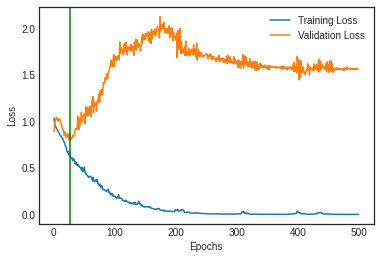

In [11]:
#plt.figure(dpi=150)
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.axvline(x=np.argmin(history.history['val_loss']), color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
print(np.argmin(history.history['val_loss']))


In [12]:
#forecasting 
n_future = 18
forecast_years = pd.date_range(start=str(list(train_years)[-1]), end=str(list(train_years)[-1]+n_future), freq='12M')
forecast = model.predict(trainX[-n_future:])
print(forecast_years)

DatetimeIndex(['2000-01-31', '2001-01-31', '2002-01-31', '2003-01-31',
               '2004-01-31', '2005-01-31', '2006-01-31', '2007-01-31',
               '2008-01-31', '2009-01-31', '2010-01-31', '2011-01-31',
               '2012-01-31', '2013-01-31', '2014-01-31', '2015-01-31',
               '2016-01-31', '2017-01-31'],
              dtype='datetime64[ns]', freq='12M')


In [13]:
#print(forecast) #this produces the values of streamflow at the scale so we need to use an inverse 
#need to consider the shape of our original transform where we have 3 variables 
#so we need to make copies 
forecast_repeat = np.repeat(forecast, df_training.shape[1], axis = -1)
#print(forecast_repeat)
y_pred_future = scaler.inverse_transform(forecast_repeat)[:,0] #grab only the first column
#print(y_pred_future) #predicted streamflow in the future 

In [14]:
#convert timestamp to year date
years = []
for year in forecast_years:
  years.append(year.date().year)

In [15]:
#combine forecast year and predicted values 
df_forecast = pd.DataFrame({"Year":np.array(years), 'Streamflow':y_pred_future})
df_forecast


,Year,Streamflow
0,2000,23.703960
1,2001,24.147892
2,2002,21.041655
3,2003,22.388929
4,2004,16.618036
5,2005,11.632339
6,2006,9.529026
7,2007,8.927719
8,2008,12.294955
9,2009,14.949434


In [16]:
#grab original data of year and streamflow 
original = df[["Year", "Streamflow"]]
original.tail()


,Year,Streamflow
107,2013,8.958391
108,2014,14.085218
109,2015,13.419005
110,2016,13.456555
111,2017,16.454849


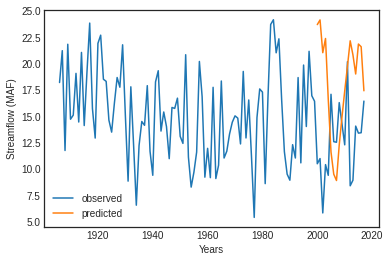

In [17]:
#plt.figure(dpi=150)
plt.plot(original['Year'],original['Streamflow'], label = "observed")
plt.plot(df_forecast['Year'], df_forecast['Streamflow'], label = 'predicted')
plt.xlabel('Years')
plt.ylabel("Streamflow (MAF)")
#plt.title('Streamflow Observation and Prediction')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(SF_data['Streamflow'][-18:], y_pred_future))
print(round(RMSE,2))
#print(len(y_pred_future))

8.69


## Repeating Experiment to Reconstructed and Longer Time Series

In [19]:
ENSO_rec_url = "https://raw.githubusercontent.com/ppuentex/ML_project/main/data/ENSO_annual_reconstructed.csv"
SF_rec_url = "https://raw.githubusercontent.com/ppuentex/ML_project/main/data/COleesmeko.csv"
ENSO_rec = pd.read_csv(ENSO_rec_url)
SF_rec = pd.read_csv(SF_rec_url)

In [25]:
#grabbing data from dates 900 to 2002 which is the period of overlap for all 3 datasets
ENSO_rec_data = ENSO_rec.iloc[:,[0,1]]
ENSO_rec_data = ENSO_rec_data.reset_index(drop=True) #reset the index for concatinating 
ENSO_rec_data.columns = ["Year", "ENSO"] #rename columns 
#print(ENSO_rec_data)
#grabbing data from dates 900 to 2002 
PMDI_rec_data = PMDI.iloc[900:2003,[0,1]]
PMDI_rec_data = PMDI_rec_data.reset_index(drop=True)
PMDI_rec_data.columns = ['Year', 'PMDI']
#print(PMDI_rec_data)
#grabbing data from dates 900 to 2002 
SF_rec_data = SF_rec.iloc[138:1241,[0,1]]
SF_rec_data = SF_rec_data.reset_index(drop=True)
SF_rec_data.columns = ['Year', 'Streamflow']
#put values of streamflow in Million Acre Feet (MAF) by dividing by 1e6
SF_rec_data.iloc[:,1] = SF_rec_data.iloc[:,1].div(1e6)
#print(SF_rec_data)

We have longer time series for our three variables now

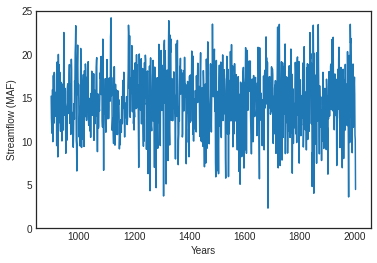

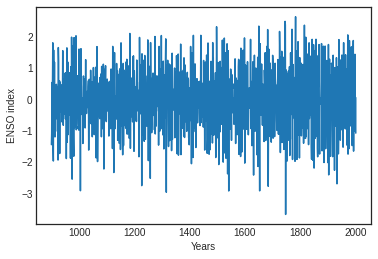

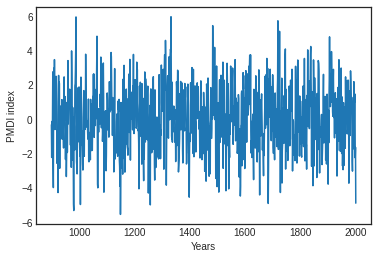

In [36]:
#plt.figure(dpi=150) #uncomment these to make figures look better for saving purposes
plt.plot(SF_rec_data['Year'], SF_rec_data['Streamflow']) #streamflow plot 
plt.ylim(0,25)
plt.ylabel("Streamflow (MAF)")
plt.xlabel('Years')
plt.show()
#plt.figure(dpi=150)
plt.plot(ENSO_rec_data['Year'], ENSO_rec_data['ENSO']) #ENSO plot 
plt.ylabel("ENSO index")
plt.xlabel('Years')
plt.show()
#plt.figure(dpi=150)
plt.plot(PMDI_rec_data['Year'], PMDI_rec_data['PMDI'])
plt.ylabel("PMDI index")
plt.xlabel("Years")
#PMDI_data.plot('Year','PMDI', title = "PMDI annual")
plt.show()

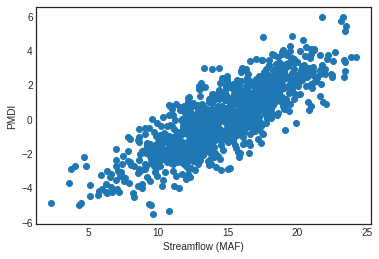

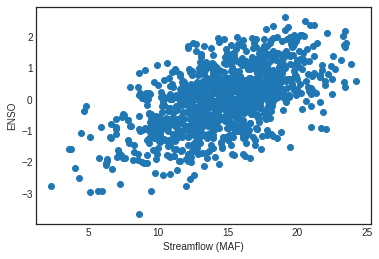

In [38]:
#plt.figure(dpi=150)
plt.scatter(SF_rec_data["Streamflow"], PMDI_rec_data["PMDI"])
plt.xlabel("Streamflow (MAF)")
plt.ylabel("PMDI")
#plt.title("Scatterplot of SF and PMDI")
plt.show()

#plt.figure(dpi=150)
plt.scatter(SF_rec_data["Streamflow"], ENSO_rec_data["ENSO"])
plt.xlabel("Streamflow (MAF)")
plt.ylabel("ENSO")
#plt.title("Scatterplot of SF and ENSO")
plt.show()

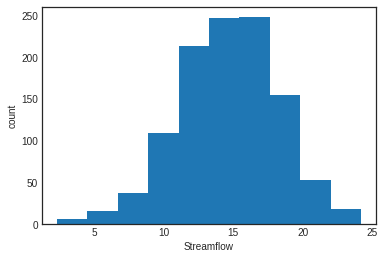

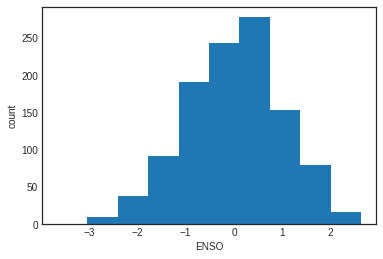

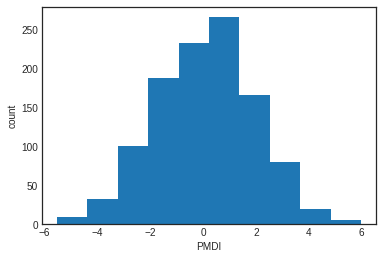

In [40]:
#plt.figure(dpi=150)
plt.hist(SF_rec_data['Streamflow'])
plt.xlabel("Streamflow")
plt.ylabel("count")
plt.show()
#plt.figure(dpi=150)
plt.hist(ENSO_rec_data['ENSO'])
plt.xlabel("ENSO")
plt.ylabel("count")
plt.show()
#plt.figure(dpi=150)
plt.hist(PMDI_rec_data['PMDI'])
plt.xlabel("PMDI")
plt.ylabel("count")
plt.show()

In [41]:
longer_data = [SF_rec_data["Year"], SF_rec_data["Streamflow"], ENSO_rec_data["ENSO"], PMDI_rec_data["PMDI"]]
header = ["Year", "Streamflow", "ENSO", "PMDI"]
longer_df=pd.concat(longer_data, axis=1,keys=header)

In [47]:
longer_df["Year"][:-96]

0        900
1        901
2        902
3        903
4        904
        ... 
1002    1902
1003    1903
1004    1904
1005    1905
1006    1906
Name: Year, Length: 1007, dtype: int64

Since our data is a lot longer, we should consider predicting the observed time (1906 to 2002)

In [69]:
#separate the years  up to 1906
longer_train_years = longer_df["Year"][:-96]
#variables for training 
cols = list(longer_df)[1:4] #grab column names 
longer_df_training = longer_df[cols][:-96].astype(float) #for normalization 


#For an LSTM network, we use signmoid so we need to normalize the dataset 
scaler = StandardScaler()
scaler = scaler.fit(longer_df_training)
df_training_scaled = scaler.transform(longer_df_training) 
print("Size of scaled training set:",df_training_scaled.shape)

#create training data set based on new scaled data 
new_trainX = []
new_trainY = []

n_future = 1 #number of years we want to predict into the future
n_past = 10 #how many years in the past we use to predict the future

#print(df_training_scaled[1:8,0:3])

for i in range(n_past, len(df_training_scaled) - n_future +1):
  new_trainX.append(df_training_scaled[i-n_past:i, 0:longer_df_training.shape[1]])
  new_trainY.append(df_training_scaled[i+n_future-1:i+n_future,0])

new_trainX = np.array(new_trainX)
new_trainY = np.array(new_trainY)

print("trainX shape", new_trainX.shape)
print("trainY shape", new_trainY.shape)

Size of scaled training set: (1007, 3)
trainX shape (997, 10, 3)
trainY shape (997, 1)


In [78]:
model = Sequential()
#model.add(LSTM(64, activation='tanh', input_shape=(new_trainX.shape[1],new_trainX.shape[2]), return_sequences=False)) #orignial layer 
model.add(LSTM(64, activation='tanh', input_shape=(new_trainX.shape[1],new_trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='tanh', input_shape=(new_trainX.shape[1],new_trainX.shape[2]), return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(new_trainY.shape[1]))
model.compile(optimizer='adam', loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(new_trainX, new_trainY, epochs = 500, batch_size=16, validation_split=0.1, verbose =0)

29


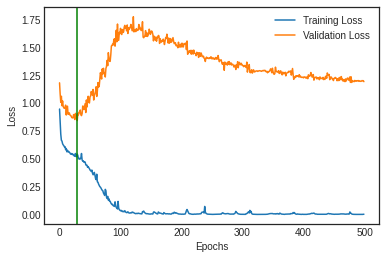

In [84]:
#plt.figure(dpi=150)
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.axvline(x=np.argmin(history.history['val_loss']), color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
print(np.argmin(history.history['val_loss']))

In [81]:
#forecasting 
n_future = 97
longer_forecast_years = pd.date_range(start=str(list(longer_train_years)[-1]), end=str(list(longer_train_years)[-1]+n_future), freq='12M')
forecast = model.predict(new_trainX[-n_future:])
#print(longer_forecast_years)

#print(forecast) #this produces the values of streamflow at the scale so we need to use an inverse 
#need to consider the shape of our original transform where we have 3 variables 
#so we need to make copies 
forecast_repeat = np.repeat(forecast, longer_df_training.shape[1], axis = -1)
#print(forecast_repeat)
y_pred_future = scaler.inverse_transform(forecast_repeat)[:,0] #grab only the first column
#print(y_pred_future) #predicted streamflow in the future 

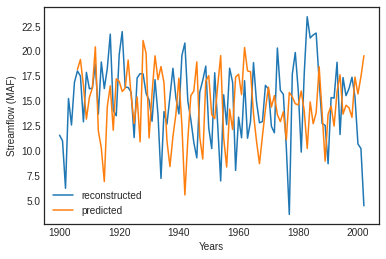

In [85]:
#convert timestamp to year date
years = []
for year in longer_forecast_years:
  years.append(year.date().year)

#combine forecast year and predicted values 
longer_df_forecast = pd.DataFrame({"Year":np.array(years), 'Streamflow':y_pred_future})
longer_df_forecast

#grab original data of year and streamflow 
longer_original = longer_df[["Year", "Streamflow"]]
longer_original.tail()

#plt.figure(dpi=150)
plt.plot(longer_original['Year'][1000:],longer_original['Streamflow'][1000:], label = "reconstructed")
plt.plot(longer_df_forecast['Year'], longer_df_forecast['Streamflow'], label = 'predicted')
plt.xlabel('Years')
plt.ylabel("Streamflow (MAF)")
#plt.title('Streamflow Observation and Prediction')
plt.legend()
plt.show()

In [83]:
new_RMSE = np.sqrt(mean_squared_error(SF_rec_data['Streamflow'][-97:], y_pred_future))
print(round(new_RMSE,2))
#print(len(y_pred_future))

5.45
